<a href="https://colab.research.google.com/github/Andrey-Shatsev/SkillFactory/blob/master/%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B4%D0%BE%D1%85%D0%BE%D0%B4%D0%B0_SAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание дохода

Целью данной задачи является построение модели <b>классификации пользователей</b>: на вход модель будет принимать данные о человеке, а на выходе она должна предсказывать бинарный уровень дохода человке (больше 50 тысяч $ за год, или меньше).

## Загрузка библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# магическая команда, указывает, что графики нужно строить прямо в ноутбуке
%matplotlib inline

In [ ]:
!pip install comet_ml # установка comet ml для логирования экспериментов

## Настройки ML set up

In [ ]:
from comet_ml import Experiment

In [ ]:
#@title CometML set up
project_name = 'incom-prediction-sag'
workspace = 'andrey-shatsev'
api_key = 'rBHUcs3eYY8d5kwdLgzSg5Mx1'

In [ ]:
experiment = Experiment(project_name=project_name, workspace=workspace, api_key = api_key, log_code=True)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/andrey-shatsev/incom-prediction-sag/c76dd6b030154eae9534d7e50d7dc536



In [ ]:
%%capture
!wget https://www.dropbox.com/s/1hfrcm09qtvoeoz/train.csv
!wget https://www.dropbox.com/s/jj7c8r0x57zda0a/test.csv

In [ ]:
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Проверим размерности наших файлов:

In [ ]:
training_data.shape, test_data.shape

((24420, 13), (8141, 13))

**Работаем с целевой переменной** 

In [ ]:
target_name = 'income'

In [ ]:
y_train = training_data[target_name]
y_test = test_data[target_name]

X_train = training_data.drop(columns=[target_name])
X_test = test_data.drop(columns=[target_name])

**Оценка сбалансированности выборки**

In [ ]:
y_train.value_counts(normalize=True)

0    0.757821
1    0.242179
Name: income, dtype: float64

Таким образом, имеем задачу **несбалансированной бинарной классификации**

## Общая статистика по числовым данным

In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


{'web': 'https://www.comet.com/api/image/download?imageId=ea76d1c0eefc4f78b3bd9ba69215eb6d&experimentKey=c76dd6b030154eae9534d7e50d7dc536',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=ea76d1c0eefc4f78b3bd9ba69215eb6d&experimentKey=c76dd6b030154eae9534d7e50d7dc536',
 'imageId': 'ea76d1c0eefc4f78b3bd9ba69215eb6d'}

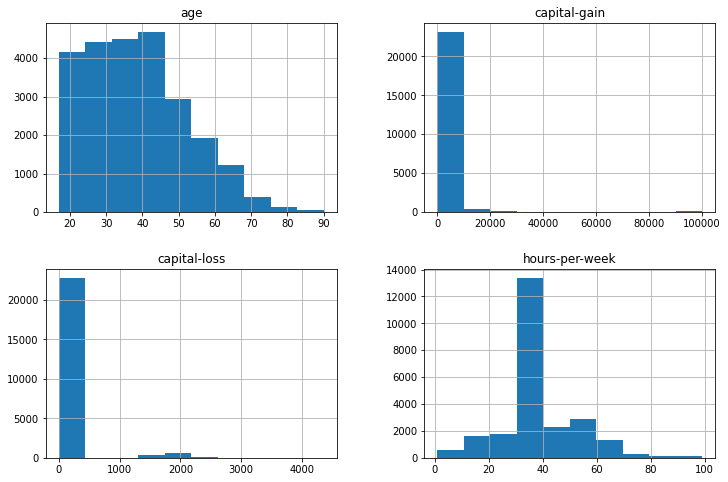

In [ ]:
X_train.hist(figsize=(12,8))
experiment.log_figure('X_train_numeric_distr', plt)

Что мы можем увидеть из результатов?


*   Числовых переменных в исходных данных только 4;
*   Возраст пользователя варьируется в диапазоне от 17 до 90 лет и в среднем составляет 39 лет;
* Видим пропуски в признаках capital-gain и capital-loss (значение count меньше размера данных). По гистограмме можно заметить, что большое количество значений в этих признаках - это просто нули;



### Предобработка данных

#### Проверка на наличие пропусков и распределение полей по типам данных

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


Типы данных у наших полей:
* 8 признаков типа **object** - обычно это строковые значения;
* 3 признака тип **int64** - целочисленные значения;
* 2 признака типа **float64** - числа с плавающей запятой.

Кроме этого, мы видим, что признаки *workclass*, *education*, *capital-gain* и *capital-loss* имеют пропуски в данных.

#### Обработка пропусков в данных

Далеко не все алгоритмы умеют работать с пропусками в данных. Кроме этого, удачно заполнив пропуски, мы сможем лучше восстановить распределение данных, а значит лучше построить моделей. 

Самые популярные методы для обработки пропусков:
- Удаление значений с пропусками (не желательно при большом количестве пропусков, потому что теряются данные);
- Заполнение средним/медианным значением;
- Заполненние самым частым значением;
- Заполнение случайным значением.

**Важно:** тестовую выборку мы всегда обрабатываем также, как и обучающую выборку. 

In [ ]:
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)

Сделаем то же самое для тестовой выборки:

In [ ]:
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)
X_test['capital-gain'] = X_test['capital-gain'].fillna(0)

In [ ]:
X_train['workclass'].value_counts(normalize=True).head(1)

Private    0.696766
Name: workclass, dtype: float64

In [ ]:
X_train['education'].value_counts(True).head(1)

HS-grad    0.322484
Name: education, dtype: float64

Наиболее частое значение признака **workclass** - Private, признака **education** - HS-grad. 

Теперь явно заполним пропуски:

In [ ]:
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

In [ ]:
X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

#### Кодировка категориальных  переменных

В данных 8 столбцов являются категориальными признаками. При чём в нашей задаче эти признаки **текстовые**. Машине сложно обрабатывать текстовые признаки, поэтому нам необходимо закодировать их, то есть преобразовать в числовые. 

Для начала необходимо выделить категорильные признаки:

In [ ]:
categorical_features = ['workclass', 'education', 'marital-status', 
                        'occupation', 'relationship', 'race', 'sex', 
                        'native-country']

non_categorical_features = ['age', 'capital-gain', 'capital-loss', 
                            'hours-per-week']

Посмотрим на столбцы категориальных переменных:

In [ ]:
X_train[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


Мы рассмотрим два популярных метода кодирования категориальных признаков:
* Label Encoding, которому соответствует класс `LabelEncoder()` из библиотеки **sklearn**
* One Hot Encoding, которому соответствует класс `OneHotEncoder()` из библиотеки **sklearn**

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [ ]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

In [ ]:
X_test_le[categorical_features]

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,Some-college,Divorced,Adm-clerical,Not-in-family,White,Female,United-States
1,State-gov,HS-grad,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States
2,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Black,Male,United-States
3,Private,Bachelors,Never-married,Machine-op-inspct,Not-in-family,White,Female,United-States
4,Self-emp-not-inc,Some-college,Divorced,Craft-repair,Not-in-family,White,Male,United-States
...,...,...,...,...,...,...,...,...
8136,Private,HS-grad,Separated,Other-service,Not-in-family,Black,Male,United-States
8137,Private,5th-6th,Married-civ-spouse,Sales,Husband,White,Male,?
8138,?,HS-grad,Never-married,?,Unmarried,Black,Female,United-States
8139,Private,Bachelors,Married-civ-spouse,Sales,Husband,White,Male,United-States


In [ ]:
for feature in categorical_features:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

In [ ]:
X_train_le.shape

(24420, 12)

**One Hot Encoding**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
onehot_encoder = OneHotEncoder()

In [ ]:
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
X_train_onehot = onehot_encoder.fit_transform(X_train[categorical_features]).toarray()

# применяем полученное преобразование к тестовой выборке, результат переводим в массив
X_test_onehot = onehot_encoder.transform(X_test[categorical_features]).toarray()

# запишем полученные названия новых колонок в отдельную переменную
columns = onehot_encoder.get_feature_names(categorical_features)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_test_onehot.shape

(8141, 102)

In [ ]:
X_train_onehot = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=columns)

И наконец, запишем в новую переменную полученный результат, удалив все незакодированные категориальные признаки из новой таблицы. 

In [ ]:
# соединяем новую табличку с исходной
X_train_new = pd.concat([X_train, X_train_onehot], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot], axis=1)

# удаляем старые категориальные признаки
X_train_new = X_train_new.drop(columns=categorical_features)
X_test_new = X_test_new.drop(columns=categorical_features)

In [ ]:
X_train_new.shape

(24420, 106)

## Обучение модели

### Выбор метода обучения классификатора

Для обучения классификатора воспользуемся логистической регрессией

In [ ]:
from sklearn.linear_model import LogisticRegression

Создаем прототип класса модели:

In [ ]:
linear_model = LogisticRegression() # возьмем default параметры логистической
# регрессии. Кодировка:  Label Encoding.
linear_model_oh = LogisticRegression() # Кодировка OneHot Encoding.

### Обучение модели на разных типах закодированных данных

In [ ]:
linear_model.fit(X_train_le, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
linear_model_oh.fit(X_train_new, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Валидация модели на тестовой выборке

In [ ]:
prediction_oh = linear_model_oh.predict(X_test_new)

In [ ]:
prediction_le = linear_model.predict(X_test_le)

In [ ]:
np.unique(prediction_oh) # есть только два вида значений: 0 и 1. Бинарная классификация.

array([0, 1])

In [ ]:
# Сколько 1го класса присутствует в предсказаниях?
round(sum(prediction_oh)/len(prediction_oh),2)

0.19

In [ ]:
# Сколько 1го класса присутствует в y_test?
round(sum(y_test)/len(y_test),2)

0.24

### Точность предсказания, логирование метрик

Посчитаем точность (accuracy) работы моделей. Напомним, что точность отражает, сколько в процентном соотношение от размера выборки модель угадала 1 класса и сколько угадала 0 класса.

Функция для подсчета точности реализована в библиоетке sklearn и называется accuracy_score().

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
acc_oh = accuracy_score(y_test, prediction_oh)

In [ ]:
# посмотрим какое значение accuracy получилось:
round(acc_oh,2)

0.85

In [ ]:
experiment.log_metric(' Accuracy OneHot data', acc_oh)

Сравним значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0. Для этого можно в функцию accuracy_score() в качестве второго аргумента передать массив нулей такого же размера. Это делается с помощью функции zeros_like() из библиотеки **numpy**.

In [ ]:
print('Accuracy Major Class: ', accuracy_score(y_test, np.zeros_like(y_test)).round(3))

Accuracy Major Class:  0.763


In [ ]:
# Залогировать accuracy для LE 

In [ ]:
acc_le = accuracy_score(y_test, prediction_le)

In [ ]:
experiment.log_metric(' Accuracy LE data', acc_le)

Посмотрим как выглядит наш новый эксперимент в Comet ML:
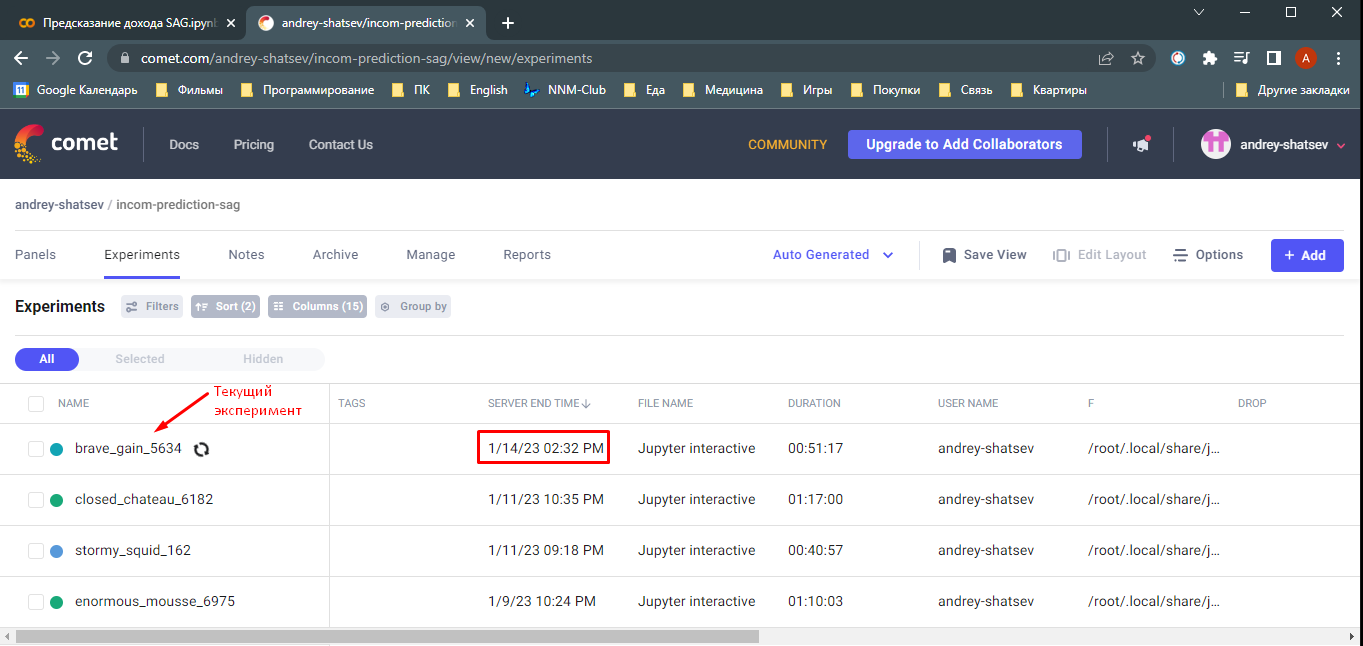

Посмотрим где увидеть залогированные метрики:

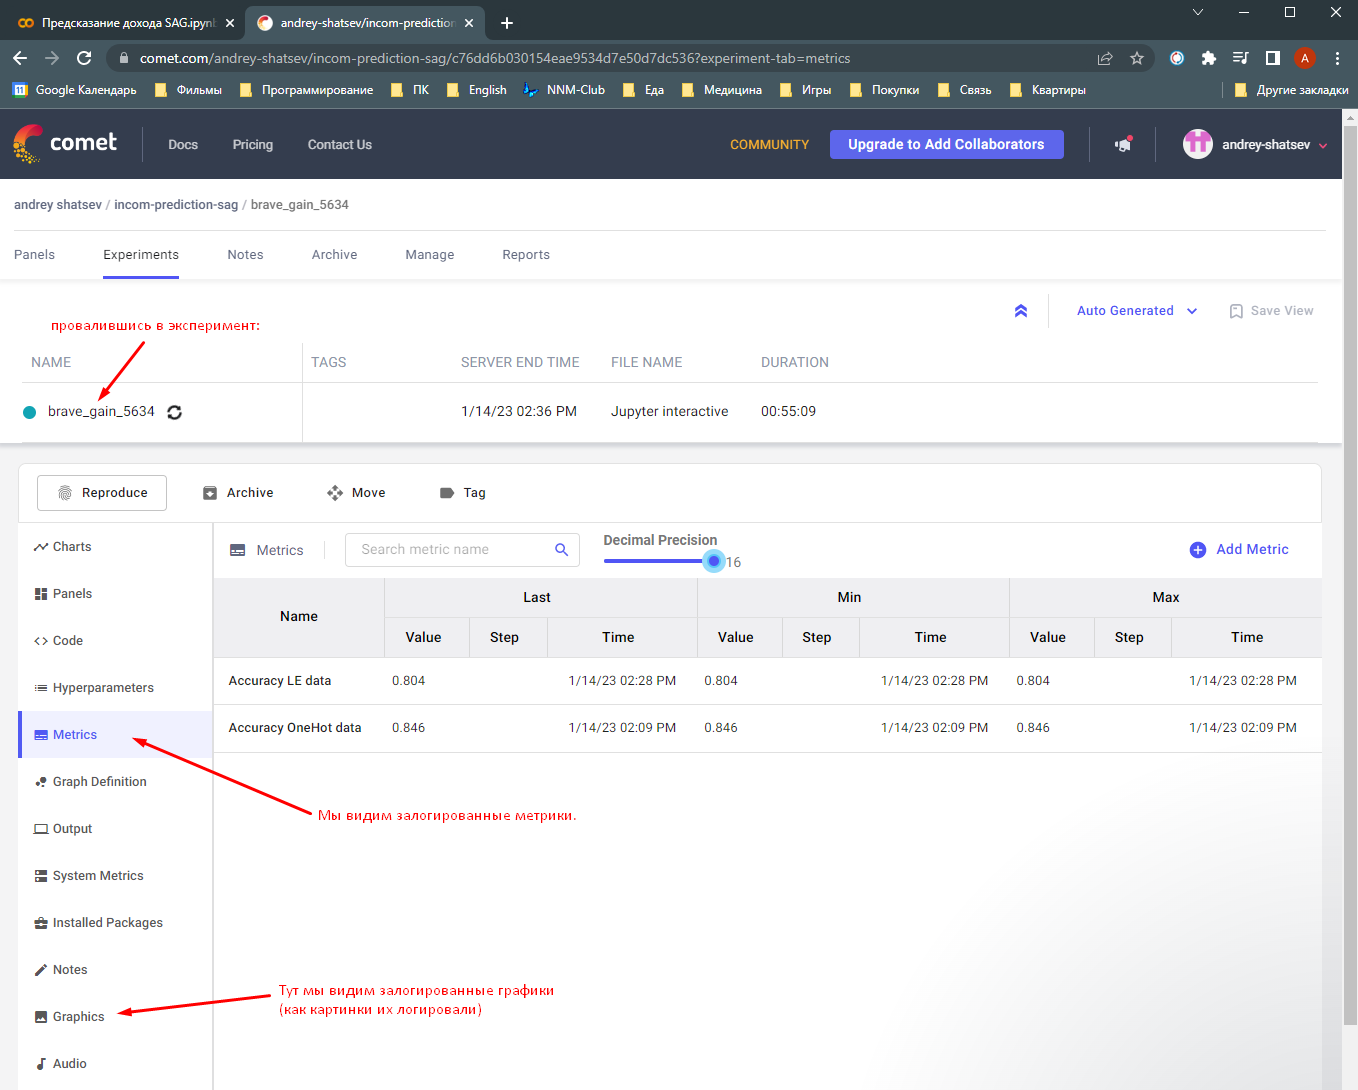

## Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатор - использовать таблицу сопряженности

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pd.DataFrame(confusion_matrix(y_test, prediction_oh))

,0,1
0,5771,443
1,806,1121


In [ ]:
# сколько 0 и 1 в y диапазоне
y_test.value_counts()

0    6214
1    1927
Name: income, dtype: int64

В таблице сопряженности строка с индексом 0 - это строка категории 0. Соответственно вторая строка с индексом 1 - это строка категории 1. Следовательно, значение с координатами (0,0) = True Negative; (0,1) - False Negative; (1,0) - False Positive; (1,1) - True Positive. Ошибки - False Negative = 443 объекта, False Positive = 806 объектов. 

In [ ]:
# залогируем таблицу сопряжености
experiment.log_confusion_matrix(y_test, prediction_oh) 

{'web': 'https://www.comet.com/api/asset/download?assetId=dabc3c127ed343d9a37d1cff0510db7b&experimentKey=c76dd6b030154eae9534d7e50d7dc536',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=dabc3c127ed343d9a37d1cff0510db7b&experimentKey=c76dd6b030154eae9534d7e50d7dc536',
 'assetId': 'dabc3c127ed343d9a37d1cff0510db7b'}

Где можно увидеть в эксперименте нашу залогированную таблицу сопряженности:
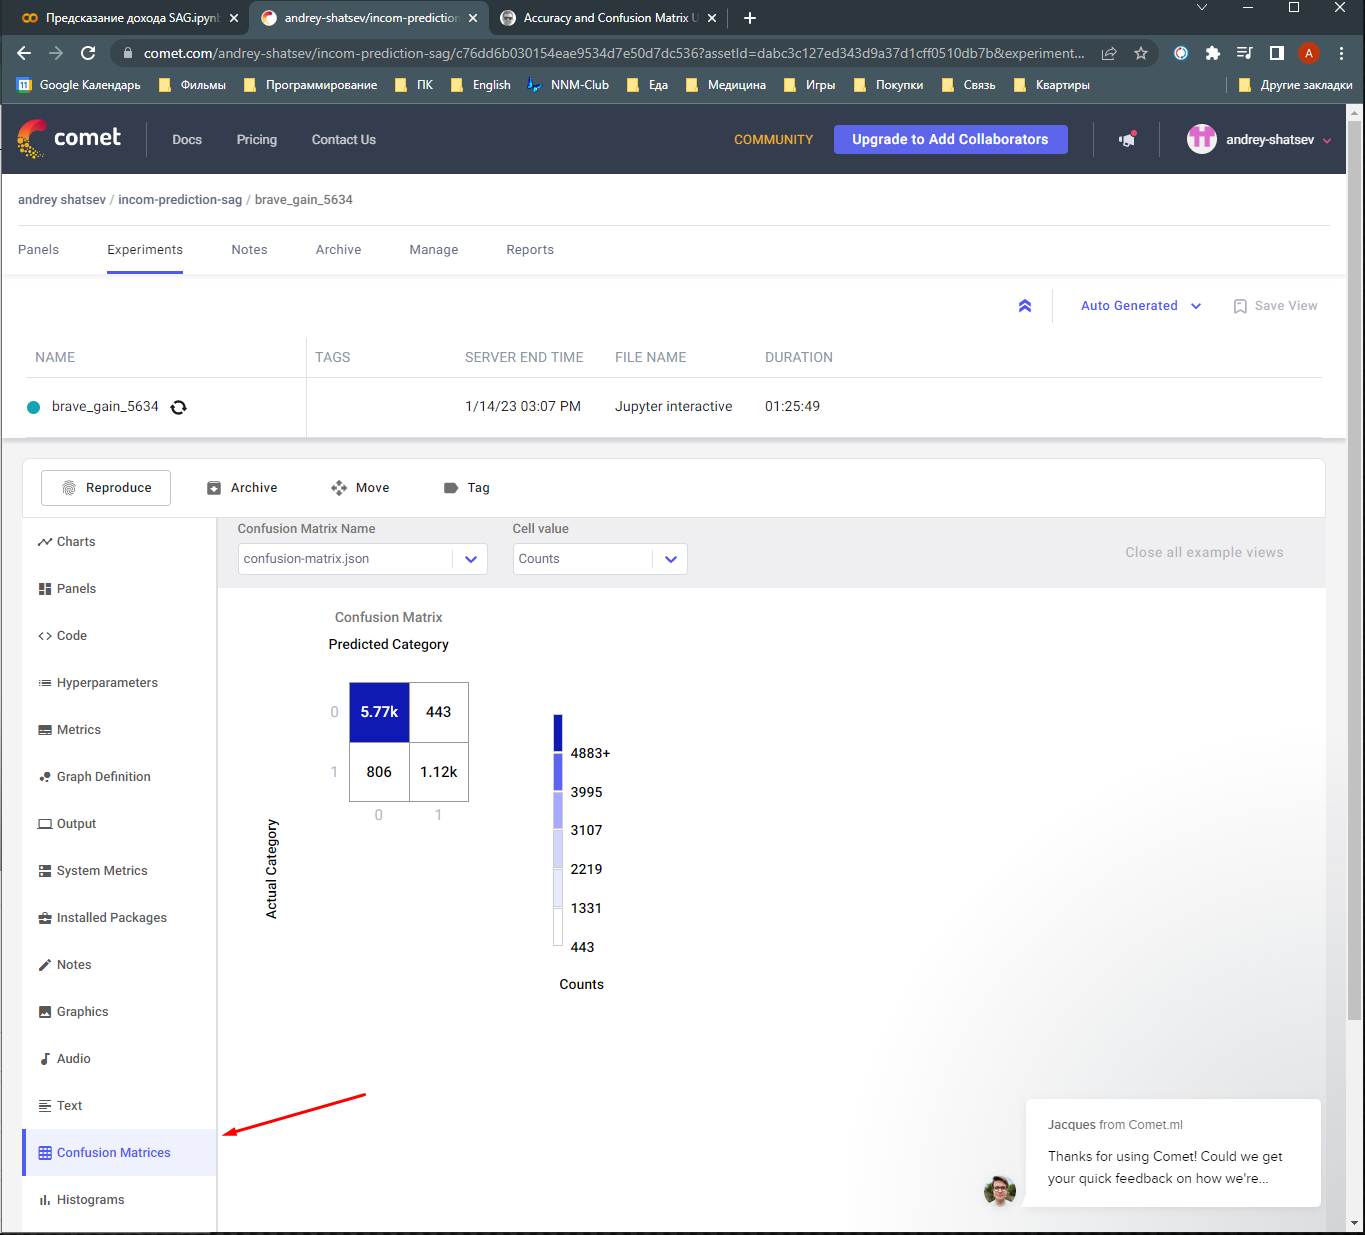

## Прогноз вероятности принадлежности к классу

In [ ]:
pred_proba_oh = linear_model_oh.predict_proba(X_test_new)

In [73]:
# Как выглядит предсказания?
pred_proba_oh

array([[0.9368583 , 0.0631417 ],
       [0.42892211, 0.57107789],
       [0.29021075, 0.70978925],
       ...,
       [0.99272798, 0.00727202],
       [0.39262546, 0.60737454],
       [0.74072524, 0.25927476]])

Первый столбец - это вероятность принадлежности к первому классу, второй столбец - вероятность принадлежности ко второму классу. В сумме, соответственно, вероятности дают значение 1.

In [ ]:
pred_proba = pred_proba_oh[:, 1] # выделим только первый столбце для оценки распределения вероятности

Посмотрим на распределение предсказанной классификатором вероятности дохода > 50k$, метки 1.

{'web': 'https://www.comet.com/api/image/download?imageId=634fa87b49ba4fe2bc1a3a2e7c4ece4a&experimentKey=c76dd6b030154eae9534d7e50d7dc536',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=634fa87b49ba4fe2bc1a3a2e7c4ece4a&experimentKey=c76dd6b030154eae9534d7e50d7dc536',
 'imageId': '634fa87b49ba4fe2bc1a3a2e7c4ece4a'}

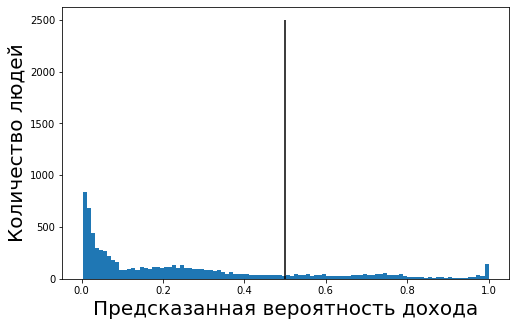

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(pred_proba, bins=100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability', plt)

На графике мы видим, что результаты сконцентрированы около значения 0, т.к. наша выборка - небалансированная. По поводу вертикальной линии - если мы сдвинем ее вправо (т.е. увеличим порог вероятности свыше которой модель относит человека к человеку с доходом в год >50k$) - увиличится надежность модели, но количество таких людей - сократится. Если сдвинем влево - то наоборот, положительным моментом выступит бОльший охват людей.

## ROC кривая классификатора

Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:
* Доля ложно положительных срабатываний: $\text{FPR}=\frac{FP}{FP+TN}$;

* Доля истинно положительных срабатываний: $\text{TPR}=\frac{TP}{TP+FN}$.

Заметим, что ***FP + TN*** дает общее число объектов класса 0, а ***TP + FN*** - общее число объектов класса 1.

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC - расшифровывается как ***Receiver Operating Characteristic***. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (***TPR***) и доли ложно позитивных срабатываний (***FPR***) при изменении порога классификации.

Функция `roc_curve()` из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога threshold, при котором достигается соответствующее значения метрик ***FPR*** и ***TPR***. 

На вход функции `roc_curve()` необходимо передать два аргумента:
* истинные значения меток
* вероятности, предсказанные моделью 

In [74]:
from sklearn.metrics import roc_curve

In [75]:
false_positive_rates, true_postive_rates, threshold = roc_curve(y_test, pred_proba)

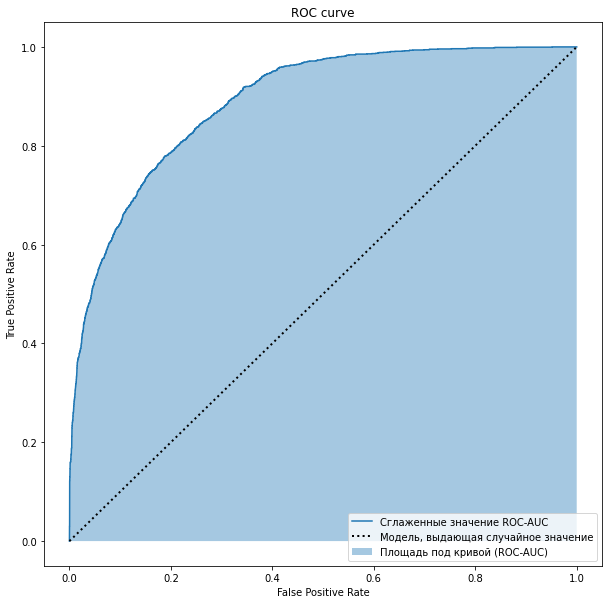

In [79]:
# создаем график
plt.figure(figsize =(10,10))

# рисуем кривую
plt.plot(false_positive_rates, true_postive_rates, label='Сглаженные значение ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0,1],[0,1], color='k', lw=2, linestyle=':',
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_postive_rates, step='pre',
                 alpha=0.4, label = 'Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

**Интерпретация**: идеальня ROC кривая - будет стремиться к единице по оси ординат (к левому вернхему краю). У нас получился - неплохой график, но сложно оценить его глазами - поэтому посчитаем площадь под кривой - чтобы получить оценку. 

In [80]:
from sklearn.metrics import roc_auc_score

In [82]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)

In [87]:
print('ROC-AUC на тестовой выборке: ', roc_auc)

ROC-AUC на тестовой выборке:  0.89


In [89]:
# залогируем его в наш Comet
experiment.log_metric('roc_auc OneHot data', roc_auc)

In [90]:
pred_proba_le = linear_model.predict_proba(X_test_le)

In [93]:
pred_proba = pred_proba_le[:, 1] # выделим только первый столбце для оценки распределения вероятности
roc_auc = roc_auc_score(y_test, pred_proba).round(3)

In [94]:
print('ROC-AUC (le) на тестовой выборке: ', roc_auc)

ROC-AUC (le) на тестовой выборке:  0.785


In [95]:
# залогируем данную оценку:
experiment.log_metric('roc_auc LE data', roc_auc)

**Итог:** алгоритмы логистической регрессии чувствительны к методам кодировки категориальных параметров.